# Modellbildung und Simulation - Übung 1

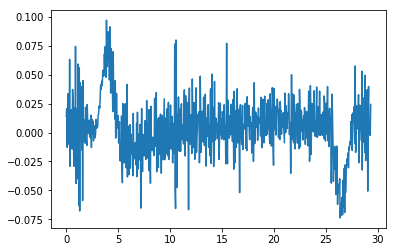

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
df1 = pd.read_csv("data/Acceleration.csv", sep=";")
plt.plot(df1['Time'], df1['Acceleration'])